In [1]:
import numpy as np
import scipy.stats as stats
import torch
import copy
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
datasets_path = "~/datasets"

with_cuda = torch.cuda.is_available()
if with_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Reminders on a toy dataset

## Building the dataset

In [3]:
def generate_image(height, width):
    img = torch.zeros((1, height, width), device = device)
    j_pos = torch.randint(2, width - 2, (1,))
    for i in range(height):
        for j in range(j_pos - 2, j_pos + 2):
            img[0, i, j] = 1
    cl = torch.randint(0, 4, (1,)).item()
    img = transforms.functional.rotate(img, 45*cl)
    return img, cl

**Question 1**

With the class `torch.utils.data.TensorDataset`, build a dataset generated by the function `generate_image`. Show some samples with matplotlib functiob `imshow`.

In [4]:
n = 1000
height = 12
width = 12

images = torch.zeros((n, 1, height, width), device = device)
classes = torch.LongTensor(n).to(device)
for i in range(n):
    images[i], classes[i] = generate_image(height, width)
    
dataset = torch.utils.data.TensorDataset(images, classes)

In [5]:
dataset.__dict__

{'tensors': (tensor([[[[0., 0., 0.,  ..., 1., 0., 0.],
            [0., 0., 0.,  ..., 1., 0., 0.],
            [0., 0., 0.,  ..., 1., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 1., 0., 0.],
            [0., 0., 0.,  ..., 1., 0., 0.],
            [0., 0., 0.,  ..., 1., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 1., 1., 0.],
            [0., 0., 0.,  ..., 1., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          ...,
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 1.,  ..., 0., 0., 0.],
            [

Text(0.5, 1.0, '2')

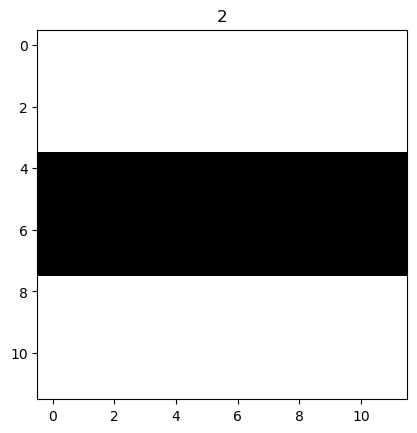

In [6]:
idx = 314
img, target = dataset[idx]
plt.imshow(img.cpu().numpy().transpose(1, 2, 0), cmap="Greys")
plt.title(target.item())

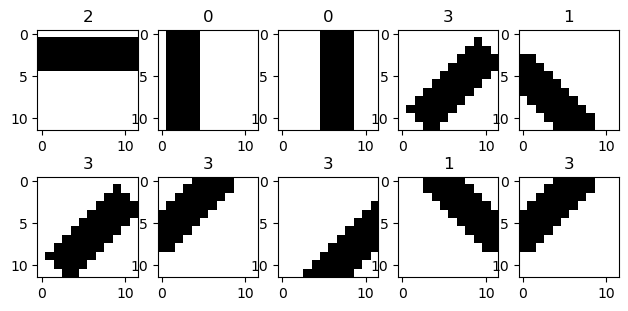

In [7]:
lst_idx = np.random.choice(n, 10, replace = False)

fig, ax = plt.subplots(2, 5, figsize = (7.5, 3.5))

for i, idx in enumerate(lst_idx):
    img, target = dataset[idx]
    ax[i//5, i%5].imshow(img.cpu().numpy().transpose(1, 2, 0), cmap="Greys")
    ax[i//5, i%5].set_title(target.item())

**Question 2**

Put the dataset into a `DataLoader`. What are the differences between a dataset and a data loader?

In [8]:
batch_size = 10
data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size)

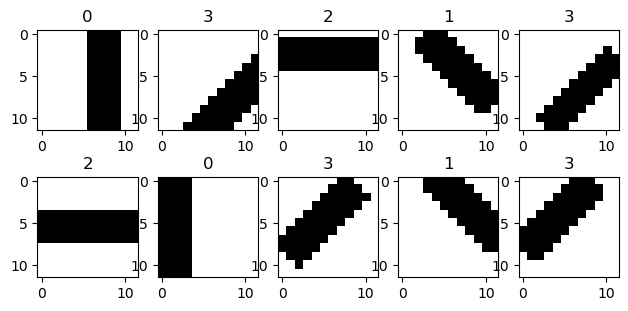

In [9]:
fig, ax = plt.subplots(2, 5, figsize = (7.5, 3.5))
for batch_img, batch_target in data_loader:
    for i, (img, target) in enumerate(zip(batch_img, batch_target)):
        ax[i//5, i%5].imshow(img.cpu().numpy().transpose(1, 2, 0), cmap="Greys")
        ax[i//5, i%5].set_title(target.item())
    break

What are Conv2d, Linear and MaxPool?

In a dataset, the elements can be accessed individually given an index (with `[i]`). 

A data loader is an `Iterable`, which means that its elements can only be accessed through an `Iterator` that traverses the dataset in a way that is provided by the arguments of the data loader (batch size, random/deterministic choice of the data points, etc.). In particular, it can be traversed with a `for` loop.

## Simple NN/training

**Question 3**

Write a neural network that classifies the data points previously generated. One can use a convolutional and a fully-connected layer.

What are the parameters of a convolutional layer? What is their shape?

In [10]:
class SmallCVNN(nn.Module):
    def __init__(self):
        super(SmallCVNN, self).__init__()

        self.act_function = torch.relu
        layers = [1, 6, 4]
        

        self.conv = torch.nn.Conv2d(layers[0], layers[1], 5)
        self.fc = torch.nn.Linear(4 * 4 * layers[1], layers[2])

    def forward(self, x):
        # Note: operator () is overloaded with Python method __call__
        #    in nn.Module, __call__ calls forward
        #    when a class A inherits from nn.Module, A() calls the implementation of forward in A.
        x = self.conv(x)
        x = self.act_function(x)
        x = torch.nn.functional.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)    # explain .view
        x = self.fc(x)
        x = torch.nn.functional.log_softmax(x, dim = 1)    # we are doing classification
        #x = torch.nn.functional.softmax(x, dim = 1)

        return x

Parameters: `conv.bias`, `conv.weight`.

`conv.bias`: size `out_channels`

`conv.weight`: size `out_channels` * `in_channels` * `kernel_height` * `kernel_width`

In [11]:
model = SmallCVNN().to(device = device)

In [12]:
model(images[:10])

tensor([[-1.4203, -1.2137, -1.7756, -1.2315],
        [-1.4887, -1.2690, -1.6075, -1.2282],
        [-1.4858, -1.2300, -1.4757, -1.3753],
        [-1.4109, -1.2496, -1.7118, -1.2415],
        [-1.5826, -1.2920, -1.7186, -1.0772],
        [-1.4595, -0.9930, -1.7868, -1.4711],
        [-1.3353, -1.1514, -1.5908, -1.5280],
        [-1.4589, -0.8398, -1.8910, -1.6885],
        [-1.5231, -1.2078, -1.6085, -1.2626],
        [-1.4781, -0.8199, -1.8774, -1.7234]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)

In [13]:
def train_model(model, criterion, optimizer, nepochs):
    #List to store loss to visualize
    train_losses = []
    train_acc = []
    start_epoch = 0

    for epoch in range(start_epoch, nepochs):
        train_loss = 0.
        valid_loss = 0.
        correct = 0

        model.train()
        for batch_idx, (data, target) in enumerate(data_loader):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            # calculate the batch loss
            loss = criterion(output, target)

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # perform a single optimization step (parameter update)
            optimizer.step()

            # update training loss
            train_loss += loss.item() * data.size(0)
            
            # accuracy
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()

        # calculate average losses
        train_loss = train_loss/len(data_loader.dataset)
        accuracy = correct/len(data_loader.dataset)*100
        train_acc.append(accuracy)
        train_losses.append(train_loss)

        # print losses statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tTraining accuracy: {:.6f}'.format(
            epoch, train_loss, accuracy))

**Question 4**

Choose the loss and train the NN. Why do we choose to minimize the loss instead of maximizing the accuracy?

In [14]:
model = SmallCVNN().to(device = device)
criterion = nn.CrossEntropyLoss()    # nn.NLLLoss()
optimizer = optim.Adam(model.parameters())
nepochs = 10

train_model(model, criterion, optimizer, nepochs)

Epoch: 0 	Training Loss: 1.195376 	Training accuracy: 60.900000
Epoch: 1 	Training Loss: 0.608768 	Training accuracy: 91.800000
Epoch: 2 	Training Loss: 0.236721 	Training accuracy: 98.700000
Epoch: 3 	Training Loss: 0.097369 	Training accuracy: 100.000000
Epoch: 4 	Training Loss: 0.046229 	Training accuracy: 100.000000
Epoch: 5 	Training Loss: 0.026318 	Training accuracy: 100.000000
Epoch: 6 	Training Loss: 0.016972 	Training accuracy: 100.000000
Epoch: 7 	Training Loss: 0.011871 	Training accuracy: 100.000000
Epoch: 8 	Training Loss: 0.008778 	Training accuracy: 100.000000
Epoch: 9 	Training Loss: 0.006756 	Training accuracy: 100.000000


The derivative of the accuracy w.r.t. the parameters of the NN is zero, so the NN cannot be trained with this "loss".

# Variational Auto-Encoders (VAE): MNIST and FashionMNIST

## Building a standard fully-connected VAE

**Question 1**

Complete the class `VAE_FC`:
 * build an encoder module;
 * build a decoder module;
 * write the method `encode`, which takes an input `x` and returns means and log-variances;
 * write the method `decode`, which takes a random variable `z` and returns the reconstructed image;
 * write the method `reparameterization`, taking means and variances and returning normal samples with these means and variances;
 * write the method `forward`, which takes an input `x` and returns its reconstruction `x_hat`, and the mean/variance of the latent representation.

Additionally:
 * write the method `sample`, which generates new data;
 * write the method `reconstruct`, which attempts to reconstruct the input.

In [15]:
batch_size = 128
#mean, std = .2860, .3530

# build transform
transform = transforms.Compose([
    transforms.ToTensor(),
    ]) 

# choose the training and test datasets
train_data = datasets.MNIST(datasets_path, train = True,
                              download = True, transform = transform)
test_data = datasets.MNIST(datasets_path, train=False,
                             download = True, transform = transform)

train_size = len(train_data)
test_size = len(test_data)

# build the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)

# specify the image classes
classes = [f"{i}" for i in range(10)]

In [16]:
class VAE_FC(nn.Module):
    def __init__(self, layers, latent_dim = 200, leak = .1):
        super(VAE_FC, self).__init__()
        
        self.layers = layers
        self.latent_dim = latent_dim
        
        # encoder
        encoder = []
        for l_in, l_out in zip(layers[:-1], layers[1:]):
            encoder += [nn.Linear(l_in, l_out), nn.LeakyReLU(leak)]

        # encoder
        self.encoder = nn.Sequential(*encoder)
        
        # latent mean and variance
        self.fc_mean = nn.Linear(layers[-1], latent_dim)
        self.fc_logvar = nn.Linear(layers[-1], latent_dim)
        
        # decoder input
        self.decoder_input = nn.Linear(latent_dim, layers[-1])
        
        # decoder
        rev_layers = list(reversed(layers))
        decoder = [nn.LeakyReLU(leak)]
        for l_in, l_out in zip(rev_layers[:-2], rev_layers[1:-1]):
            decoder += [nn.Linear(l_in, l_out), nn.LeakyReLU(leak)]
        decoder += [nn.Linear(layers[1], layers[0]), nn.Sigmoid()]
        self.decoder = nn.Sequential(*decoder)
     
    def encode(self, x):
        x = x.view(x.size(0), -1)
        x = self.encoder(x)
        mean, logvar = self.fc_mean(x), self.fc_logvar(x)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(logvar).to(device)      
        z = mean + (.5*logvar).exp() * epsilon
        return z

    def decode(self, x):
        x = self.decoder_input(x)
        x = self.decoder(x)
        return x.view(x.size(0), 1, 28, 28)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar
    
    def sample(self, num_samples):
        with torch.no_grad():
            z = torch.randn(num_samples, self.latent_dim, device = device)
            samples = self.decode(z)

            return samples
    
    def reconstruct(self, x):
        with torch.no_grad():
            mean, logvar = self.encode(x)
            return self.decode(mean)

**Question 2**

Write the function `build_loss_vae`, which builds the loss function for the VAE. The reconstruction loss and the KL loss will be balanced by two parameters `lambda_reconstruct` and `lambda_kl` (by default, they are equal to 0.5).

In [17]:
# Note about closures

def build_loss_vae(lambda_reconstruct = .5, lambda_kl = .5):
    def loss_vae(x, x_hat, mean, logvar):
        reconstruct_loss = lambda_reconstruct * (x - x_hat).pow(2).sum()
        KL_loss = -lambda_kl * torch.sum(logvar - mean.pow(2) - logvar.exp())

        return reconstruct_loss + KL_loss
    return loss_vae

## Training

In [18]:
def train_model_vae(data_loader, model, criterion, optimizer, nepochs):
    #List to store loss to visualize
    train_losses = []
    train_acc = []
    start_epoch = 0

    for epoch in range(start_epoch, nepochs):
        train_loss = 0.
        valid_loss = 0.
        correct = 0

        model.train()
        for batch_idx, (input_, target) in enumerate(data_loader):
            input_ = input_.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # forward pass: compute predicted outputs by passing inputs to the model
            output_, mean, logvar = model(input_)

            # calculate the batch loss
            loss = criterion(input_, output_, mean, logvar)

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # perform a single optimization step (parameter update)
            optimizer.step()

            # update training loss
            train_loss += loss.item() * input_.size(0)

        # calculate average losses
        train_loss = train_loss/len(data_loader.dataset)
        train_losses.append(train_loss)

        # print losses statistics 
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, train_loss))

**Question 3**

Train the VAE on MNIST or FashionMNIST. Don't forget to save it!

In [19]:
lambda_reconstruct = .5
lambda_kl = .5

latent_dim = 10
layers = [28**2, 500, 200, 50]
model = VAE_FC(layers, latent_dim = latent_dim).to(device)
criterion = build_loss_vae(lambda_reconstruct = lambda_reconstruct, lambda_kl = lambda_kl)
optimizer = optim.Adam(model.parameters())
nepochs = 30

#train_model_vae(train_loader, model, criterion, optimizer, nepochs)

#torch.save({"vae_fc": model.state_dict()}, "VAE_FC_MNIST.pkl")
#torch.save({"vae_fc": model.state_dict()}, "VAE_FC_FashionMNIST.pkl")

dct_load = torch.load("VAE_FC_MNIST.pkl", weights_only = True)
#dct_load = torch.load("VAE_FC_FashionMNIST.pkl", weights_only = True)
model.load_state_dict(dct_load["vae_fc"])

<All keys matched successfully>

**Question 4**

With the resulting model:
 * show some generated samples;
 * check the quality of the reconstruction;
 * show some interpolations between images.

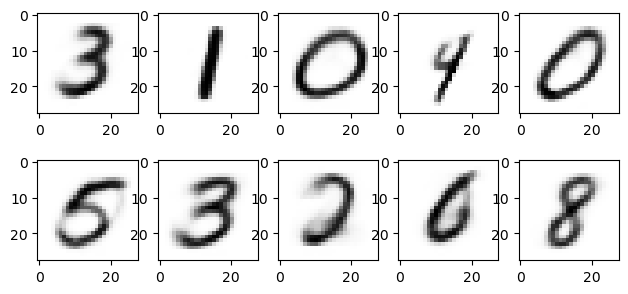

In [20]:
x = model.sample(10)

fig, ax = plt.subplots(2, 5, figsize = (7.5, 3.5))
for i, img in enumerate(x):
    ax[i//5, i%5].imshow(img.cpu().detach().numpy().transpose(1, 2, 0), cmap="Greys")

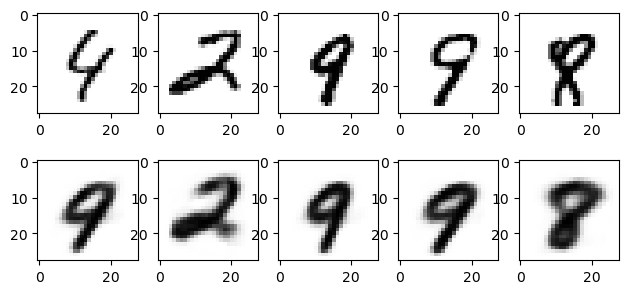

In [21]:
lst_idx = np.random.choice(50000, 5, replace = False)

fig, ax = plt.subplots(2, 5, figsize = (7.5, 3.5))

for i, idx in enumerate(lst_idx):
    img, target = train_data[idx]
    ax[0, i].imshow(img.cpu().numpy().transpose(1, 2, 0), cmap="Greys")
    img_reconstr = model.reconstruct(img.to(device))
    ax[1, i].imshow(img_reconstr[0].cpu().numpy().transpose(1, 2, 0), cmap="Greys")

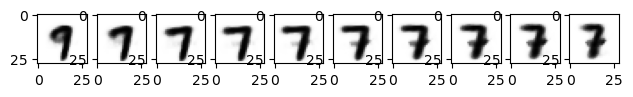

In [22]:
lst_idx = np.random.choice(50000, 2, replace = False)
x1, _ = train_data[lst_idx[0]]
x2, _ = train_data[lst_idx[1]]
x1 = x1.to(device)
x2 = x2.to(device)

fig, ax = plt.subplots(1, 10, figsize = (7.5, 3.5))

with torch.no_grad():
    _, mean1, _ = model(x1)
    _, mean2, _ = model(x2)

n_interp = 10

lst_lambd = torch.linspace(0, 1, n_interp)
    
for i, lambd in enumerate(lst_lambd):
    mean = (1 - lambd) * mean1 + lambd * mean2
    with torch.no_grad():
        y = model.decode(mean)
        
    ax[i].imshow(y[0].cpu().numpy().transpose(1, 2, 0), cmap="Greys")

## Conditional VAE

**Question 5**

Modify the VAE to build a conditional VAE:
 * the input vectors should be enriched with a one-hot vector coding for the class;
 * when sent to the decoder, the latent representation should be enriched with a one-hot vector coding for the class.

Modify also the function `train_model_vae`.

In [23]:
class CondVAE_FC(nn.Module):
    def __init__(self, layers, latent_dim = 200, leak = .1, cond = False, n_classes = 10):
        super(CondVAE_FC, self).__init__()
        
        self.cond = cond
        self.layers = layers
        self.latent_dim = latent_dim
        
        enc_layers = copy.deepcopy(layers)
        if cond:
            enc_layers[0] += n_classes
        
        # encoder
        encoder = []
        for l_in, l_out in zip(enc_layers[:-1], enc_layers[1:]):
            encoder += [nn.Linear(l_in, l_out), nn.LeakyReLU(leak)]

        # encoder
        self.encoder = nn.Sequential(*encoder)
        
        # latent mean and variance
        self.fc_mean = nn.Linear(layers[-1], latent_dim)
        self.fc_logvar = nn.Linear(layers[-1], latent_dim)
        
        # decoder input
        if cond:
            self.decoder_input = nn.Linear(latent_dim + n_classes, layers[-1])
        else:
            self.decoder_input = nn.Linear(latent_dim, layers[-1])
        
        # decoder
        rev_layers = list(reversed(layers))
        decoder = []
        for l_in, l_out in zip(rev_layers[:-2], rev_layers[1:-1]):
            decoder += [nn.Linear(l_in, l_out), nn.LeakyReLU(leak)]
        decoder += [nn.Linear(layers[1], layers[0]), nn.Sigmoid()]
        self.decoder = nn.Sequential(*decoder)
     
    def encode(self, x, y = None):
        x = x.view(x.size(0), -1)
        if self.cond:
            y = F.one_hot(y, num_classes = 10)
            x = torch.cat((x, y), dim = -1)
            
        x = self.encoder(x)
        mean, logvar = self.fc_mean(x), self.fc_logvar(x)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(logvar).to(device)      
        z = mean + logvar.exp() * epsilon
        return z

    def decode(self, x, y = None, y_vect = None):
        if self.cond:
            if y is not None:
                y = F.one_hot(y, num_classes = 10)
                x = torch.cat((x, y), dim = -1)
            elif y_vect is not None:
                x = torch.cat((x, y_vect), dim = -1)
            else:
                raise NotImplementedError("Both y and y_vect are None.")
        x = self.decoder_input(x)
        x = self.decoder(x)
        return x.view(x.size(0), 1, 28, 28)

    def forward(self, x, y = None):
        mean, logvar = self.encode(x, y)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z, y)
        return x_hat, mean, logvar
    
    def sample(self, num_samples, y = None):
        with torch.no_grad():
            z = torch.randn(num_samples, self.latent_dim, device = device)
            samples = self.decode(z, y)

            return samples
    
    def reconstruct(self, x):
        with torch.no_grad():
            mean, logvar = self.encode(x)
            return self.decode(mean)

In [24]:
def train_model_vae(data_loader, model, criterion, optimizer, nepochs, cond = False):
    #List to store loss to visualize
    train_losses = []
    train_acc = []
    start_epoch = 0

    for epoch in range(start_epoch, nepochs):
        train_loss = 0.
        valid_loss = 0.
        correct = 0

        model.train()
        for batch_idx, (input_, target) in enumerate(data_loader):
            input_ = input_.to(device)
            target = target.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # forward pass: compute predicted outputs by passing inputs to the model
            if cond:
                output_, mean, logvar = model(input_, target)
            else:
                output_, mean, logvar = model(input_)

            # calculate the batch loss
            loss = criterion(input_, output_, mean, logvar)

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # perform a single optimization step (parameter update)
            optimizer.step()

            # update training loss
            train_loss += loss.item() * input_.size(0)

        # calculate average losses
        train_loss = train_loss/len(data_loader.dataset)
        train_losses.append(train_loss)

        # print losses statistics 
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, train_loss))

**Question 6**

Train the model.

With the resulting model:
 * show some generated samples;
 * check the quality of the reconstruction;
 * show some interpolations between images.

In [25]:
lambda_reconstruct = .5
lambda_kl = .5

cond = True
latent_dim = 10
layers = [28**2, 500, 200, 50]
model = CondVAE_FC(layers, latent_dim = latent_dim, cond = cond).to(device)
criterion = build_loss_vae(lambda_reconstruct = lambda_reconstruct, lambda_kl = lambda_kl)
optimizer = optim.Adam(model.parameters())
nepochs = 30

#train_model_vae(train_loader, model, criterion, optimizer, nepochs, cond = cond)
#torch.save({"vae_fc": model.state_dict()}, "CVAE_FC_MNIST.pkl")
#torch.save({"vae_fc": model.state_dict()}, "CVAE_FC_FashionMNIST.pkl")

dct_load = torch.load("CVAE_FC_MNIST.pkl", weights_only = True)
#dct_load = torch.load("CVAE_FC_FashionMNIST.pkl", weights_only = True)
model.load_state_dict(dct_load["vae_fc"])

<All keys matched successfully>

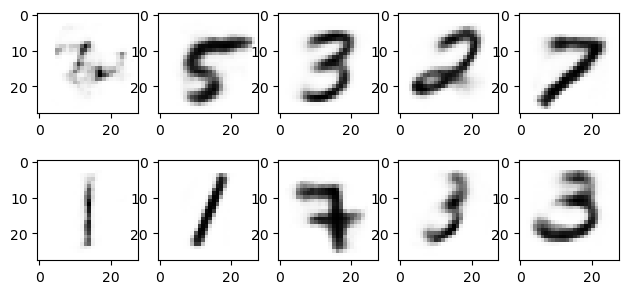

In [26]:
y = torch.randint(10, size = (10,), device = device)
x = model.sample(10, y)

fig, ax = plt.subplots(2, 5, figsize = (7.5, 3.5))
for i, img in enumerate(x):
    ax[i//5, i%5].imshow(img.cpu().detach().numpy().transpose(1, 2, 0), cmap="Greys")

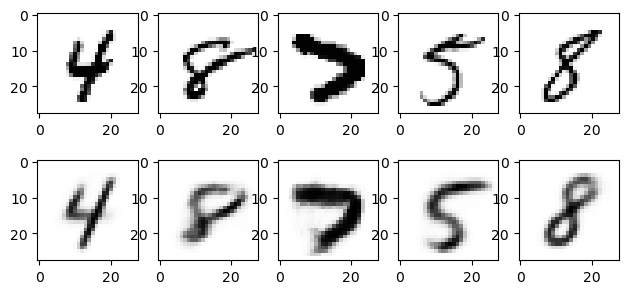

In [27]:
lst_idx = np.random.choice(50000, 5, replace = False)

fig, ax = plt.subplots(2, 5, figsize = (7.5, 3.5))

for i, idx in enumerate(lst_idx):
    img, target = train_data[idx]
    ax[0, i].imshow(img.cpu().numpy().transpose(1, 2, 0), cmap="Greys")
    with torch.no_grad():
        img_reconstr, _, _ = model(img.to(device), torch.LongTensor([target]).to(device))
    ax[1, i].imshow(img_reconstr[0].cpu().numpy().transpose(1, 2, 0), cmap="Greys")

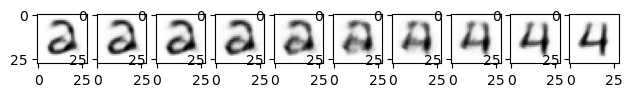

In [28]:
y = torch.randint(10, size = (2, 1), device = device).to(dtype = torch.long)
#y = F.one_hot(y, num_classes = 10)
#np.random.choice(50000, 5, replace = False)
y1_vect = F.one_hot(y[0], num_classes = 10)
y2_vect = F.one_hot(y[1], num_classes = 10)

with torch.no_grad():
    z = torch.randn(1, model.latent_dim, device = device)
    x1 = model.decode(z, y_vect = y1_vect)
    x2 = model.decode(z, y_vect = y2_vect)

fig, ax = plt.subplots(1, 10, figsize = (7.5, 3.5))

n_interp = 10

lst_lambd = torch.linspace(0, 1, n_interp)

for i, lambd in enumerate(lst_lambd):
    y_interp = (1 - lambd) * y1_vect + lambd * y2_vect
    with torch.no_grad():
        x = model.decode(z, y_vect = y_interp)
        x_hat = x.view(x.size(0), 1, 28, 28)
        
    ax[i].imshow(x_hat[0].cpu().numpy().transpose(1, 2, 0), cmap="Greys")

# Variational inference

The goal is to build a variational inference (VI) model. We will use the family of independent Gaussian distributions, which means that each parameter $\theta_k$ of the model will be randomly generated w.r.t. a Gaussian distribution $\mathcal{N}(\mu_k, \sigma_k^2)$. The parameters to be learned are the $(\mu_1, \sigma_1^2, \cdots, \mu_p, \sigma_p^2)$.

To simplify, we will work with a multilayer perceptron. For each pass trhough the model, we will generate randomly the weights and the biases w.r.t. their own Gaussian distribution.

In [29]:
batch_size = 128
#mean, std = .2860, .3530

# build transform
transform = transforms.Compose([
    transforms.ToTensor(),
    ]) 

# choose the training and test datasets
train_data = datasets.MNIST(datasets_path, train = True,
                              download = True, transform = transform)
test_data = datasets.MNIST(datasets_path, train=False,
                             download = True, transform = transform)

train_size = len(train_data)
test_size = len(test_data)

# build the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)

# specify the image classes
classes = [f"{i}" for i in range(10)]

**Question 1**

Build a `Module` named `LinearVI` that is similar to the `Linear` layer, but contains the means and variances of the independent Gaussian distributions generating the weights and the biases:
* the log-variances will be stored instead the variances themselves;
* the means/log-variances should be implemented both for the weights and the biases;
* the `forward` method should be implemented: it is recommended to start with generating Gaussian noise, and then translate and scale it to obtain the weights and biases; one can use the function `F.Linear` to compute the output;
* the attributes `weight_prior_logvar` and `bias_prior_logvar` contain the initialization log-variance for the weighs and for the biases.

In [30]:
class LinearVI(nn.Module):
    def __init__(self, *args, **kwargs):
        super(LinearVI, self).__init__()
        
        self.args = args
        self.kwargs = kwargs
        
        self.module_means = nn.Linear(*args, **kwargs)
        self.module_logvars = nn.Linear(*args, **kwargs)
        n_in = self.module_logvars.weight.size(1)
        self.weight_prior_logvar = np.log(1 / n_in)
        self.bias_prior_logvar = np.log(.01)
        
        with torch.no_grad():
            self.module_logvars.weight.fill_(self.weight_prior_logvar)
            self.module_logvars.bias.fill_(self.bias_prior_logvar)
        
    def forward(self, x):
        if not self.training:
            return self.module_means(x)
        
        device = x.device
        
        weight = self.module_means.weight \
            + (torch.randn(self.module_means.weight.size(), device = device)
               * (.5 * self.module_logvars.weight).exp())
        bias = self.module_means.bias \
            + (torch.randn(self.module_means.bias.size(), device = device)
               * (.5 * self.module_logvars.bias).exp())
        
        return F.linear(x, weight, bias)
    
    def loss_kl(self):
        kl_weight = .5 * (self.weight_prior_logvar - self.module_logvars.weight) \
            + (self.module_logvars.weight.exp() + self.module_means.weight.pow(2)) \
            / (2*np.exp(self.weight_prior_logvar))
        kl_bias = .5 * (self.bias_prior_logvar - self.module_logvars.bias) \
            + (self.module_logvars.bias.exp() + self.module_means.bias.pow(2)) \
            / (2*np.exp(self.bias_prior_logvar))
        return kl_weight.sum() + kl_bias.sum()

**Question 2**

Build a multilayer perceptron `PerceptronVI` made of fully-connected variational layers (`LinearVI`).

In [31]:
class PerceptronVI(torch.nn.Module):
    def __init__(self, layers):
        super(PerceptronVI, self).__init__()

        self.act_function = torch.relu

        self.layers = torch.nn.ModuleList()
        for l_in, l_out in zip(layers[:-1], layers[1:]):
            self.layers.append(LinearVI(l_in, l_out))
        self.nb_layers = len(self.layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers[:-1]:
            x = l(x)
            x = self.act_function(x)
                                       
        x = self.layers[-1](x)
        x = torch.nn.functional.log_softmax(x, dim = 1)

        return x
    
    def loss_kl(self):
        s = 0
        for l in self.layers:
            s = s + l.loss_kl()
        return s

**Question 3**

Complete the train function below. The `loss_kl` is defined as:
$$
L(\boldsymbol{\theta}) = \lambda \sum_{k = 1}^p \left[ \frac{1}{2} \log\left(\frac{\sigma_{0k}^2}{\sigma_k^2}\right) +\frac{\sigma_k^2 + \mu_k^2}{2 \sigma_{0k}^2} + \frac{1}{2}\right] ,
$$
where $\sigma_{0k}^2$ is the variance of the prior distribution on $\theta_k$ (defined for each layer via `weight_prior_logvar` and `bias_prior_logvar`) and $\lambda$ is the penalty factor `pen_factor`.

It is recommended to add new methods to `LinearVI` and `PerceptronVI`.

In [32]:
def train_model_vi(model, criterion, optimizer, nepochs, pen_factor = 1/60000):
    #List to store loss to visualize
    train_losses = []
    train_acc = []
    start_epoch = 0

    for epoch in range(start_epoch, nepochs):
        train_loss = 0.
        valid_loss = 0.
        correct = 0

        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            # calculate the batch loss
            loss_fit = criterion(output, target)
            loss_kl = pen_factor * model.loss_kl()
            loss = loss_fit + loss_kl

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # perform a single optimization step (parameter update)
            optimizer.step()

            # update training loss
            train_loss += loss.item() * data.size(0)
            
            # accuracy
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()

        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        accuracy = correct/len(train_loader.dataset)*100
        train_acc.append(accuracy)
        train_losses.append(train_loss)

        # print losses statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tTraining accuracy: {:.6f}'.format(
            epoch, train_loss, accuracy))

**Question 4**

Train the model for various $\lambda$ and plot the posterior distributions obtained for parameters of different layers.

In [33]:
model = PerceptronVI([28**2, 500, 200, 100, 10]).to(device = device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
nepochs = 10

pen_factor = .1/60000
train_model_vi(model, criterion, optimizer, nepochs, pen_factor)

Epoch: 0 	Training Loss: 1.579239 	Training accuracy: 63.223333
Epoch: 1 	Training Loss: 0.830836 	Training accuracy: 92.286667
Epoch: 2 	Training Loss: 0.754514 	Training accuracy: 94.441667
Epoch: 3 	Training Loss: 0.725547 	Training accuracy: 95.225000
Epoch: 4 	Training Loss: 0.708033 	Training accuracy: 95.721667
Epoch: 5 	Training Loss: 0.697107 	Training accuracy: 96.060000
Epoch: 6 	Training Loss: 0.686003 	Training accuracy: 96.315000
Epoch: 7 	Training Loss: 0.683584 	Training accuracy: 96.415000
Epoch: 8 	Training Loss: 0.672743 	Training accuracy: 96.503333
Epoch: 9 	Training Loss: 0.668133 	Training accuracy: 96.595000


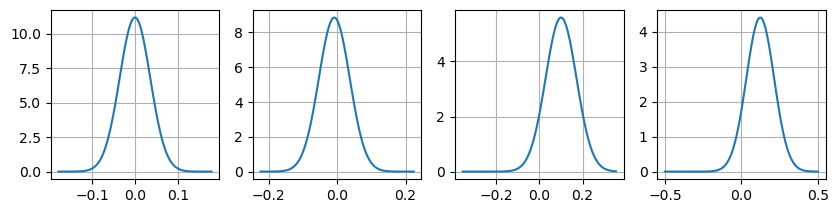

In [34]:
fig, ax = plt.subplots(1, 4, figsize = (10, 2.2))

coord = (1, 1)

for i, l in enumerate(model.layers):
    prior_std = np.sqrt(1/l.module_means.weight.size(1))
    mean = l.module_means.weight[coord].cpu().detach()
    std = (.5 * l.module_logvars.weight[coord].cpu().detach()).exp()
    
    x = np.linspace(-5 * prior_std, 5 * prior_std, 100)
    ax[i].plot(x, stats.norm.pdf(x, mean, std))
    ax[i].grid()